# lifetime time calibration - store maps

### JAH  03/08/18

<i>
This notebook compues the lifetime map (scale and lifetime) and stores it in a file.
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Aug  4 22:19:03 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number                 = 6206
input_dst_filenames        = [f"$IC_DATA/dsts/kdst_{run_number}_0_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_1_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_2_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_3_filtered.h5"
                             ]
run_number_correction      = 6165
bootstrap_correction_filename = f"$IC_DATA/maps/corrections_run{run_number_correction}.h5"
correction_filename           = f"$IC_DATA/maps/akr_corrections_run{run_number}.h5"

apply_geocorrection = True
delta_time          = 1.   # map every hour

Rrange  =    0., 200.
Zrange  =    0., 550.
XYrange = -200., 200.
E0range = 6.5e3, 13.5e3
LTrange = 1.5e3,  3.0e3

XYnbins      =  100


### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf

from invisible_cities.core .core_functions import in_range

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.utils.hst_extend_functions as hst
import krcal.utils.plt_functions        as apt
import krcal.utils.kdst_functions       as kdstf
import krcal.dev.akr_functions          as akr
import krcal.dev.corrections            as corrections

In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [6]:
input_dst_filenames           = [os.path.expandvars(fi) for fi in input_dst_filenames]
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
correction_filename           = os.path.expandvars(correction_filename)

In [7]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

## Read data

In [8]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 4534806 
Total number of events: 4534806


## Relevant data and corrections

In [9]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
R   = dst.R   .values
Phi = dst.Phi .values
S2e = dst.S2e .values
S2q = dst.S2q .values
T   = dst.time.values
TH  = (T - T.min())/3600. # time in hours

In [10]:
if (apply_geocorrection):
    calibrate = corrections.Calibration(bootstrap_correction_filename)
    print('Applying geometrical corrections: E, Q')
    E, Q = calibrate(X, Y, None, T, S2e, S2q)
else:
    E, Q = S2e, S2q

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/corrections_run6165.h5
node             : geometry
Applying geometrical corrections: E, Q


## Global lifetime

In [11]:
sel_r = in_range(R, *Rrange)
sel_z = in_range(Z, *Zrange)
sel   = sel_r & sel_z

In [12]:
Znbins = 50
Enbins, Erange = 50, (6e3, 14e3)

In [13]:
e0, lt, chi2, ok = akr.lt_lsqfit(Z[sel], E[sel], nbins=Znbins)
print('e0, lt  (unbinned)', e0.value, lt.value, ' chi2 ', chi2)

e0, lt  (unbinned) 12365.4768794 2336.1870225  chi2  8.06434156326


e0, lt  (binned)  [ 12366.61454766  -2341.7239937 ] chi2 7.62891080845


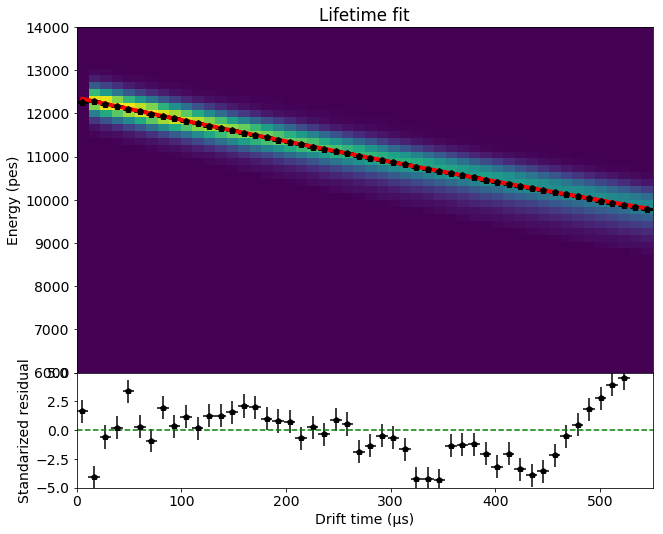

In [14]:
f = akr.lt(Z[sel], E[sel], Znbins, Zrange, Enbins, Erange, plot = True);
print('e0, lt  (binned) ', f.values, 'chi2', f.chi2)

## Study map 

In [15]:
XYa = hst.Vaxis( XYrange, nbins = XYnbins)

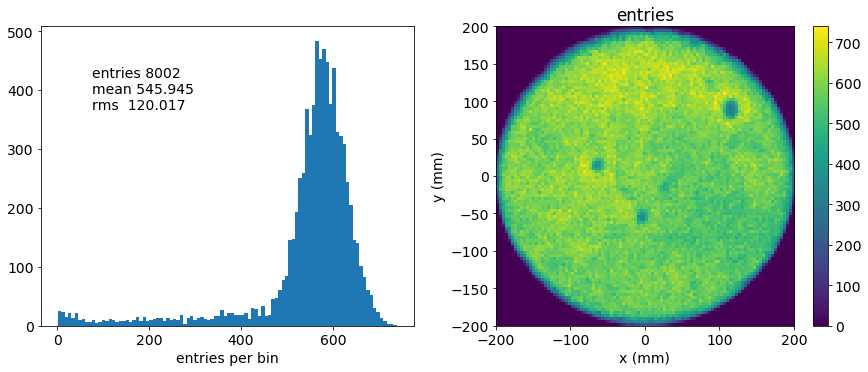

In [16]:
c = hst.Canvas(1, 2)
nevt, *_ = hst.hist2d(X[sel], Y[sel], (XYa.bins, XYa.bins), canvas=c(2), 
                      xylabels = ('x (mm)', 'y (mm)', 'entries'))
plt.colorbar()
oks = nevt > 0
hst.hist(nevt[oks].flatten(), 100, canvas = c(1), xylabels = ('entries per bin', ''));
plt.tight_layout()

In [17]:
xye0, xylt, xychi2, xyok = akr.ltmap_lsqfit(X[sel], Y[sel], Z[sel], S2e[sel], XYa.bins)

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


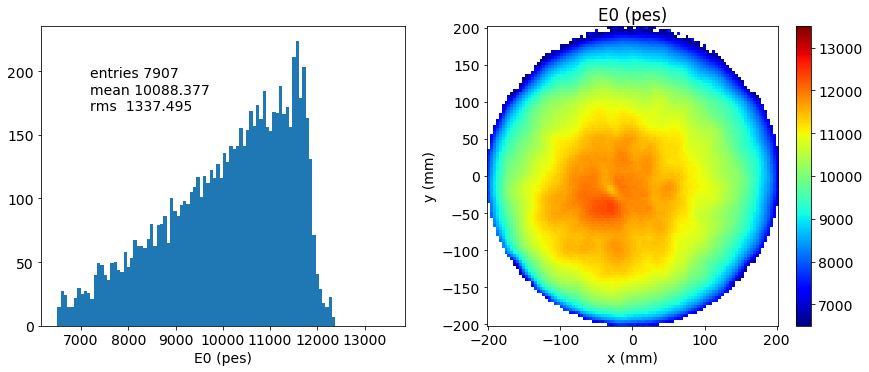

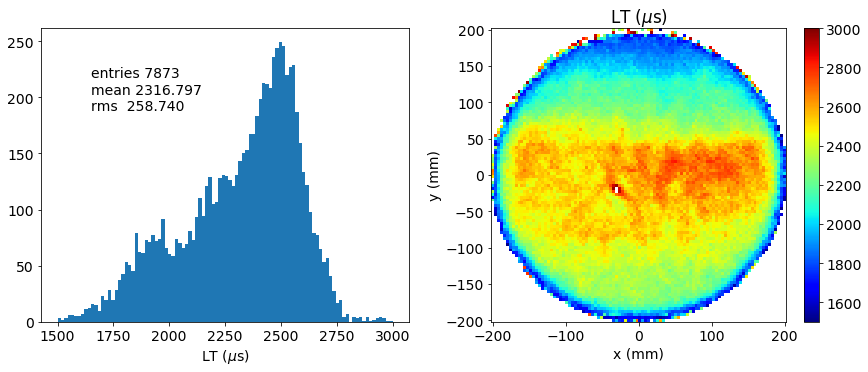

In [18]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
apt.plt_xymap(XYa.centers, XYa.centers, xye0.value, xyok, XYa.nbins, E0range, 'E0 (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xylt.value, xyok, XYa.nbins, LTrange, 'LT ($\mu$s)');

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


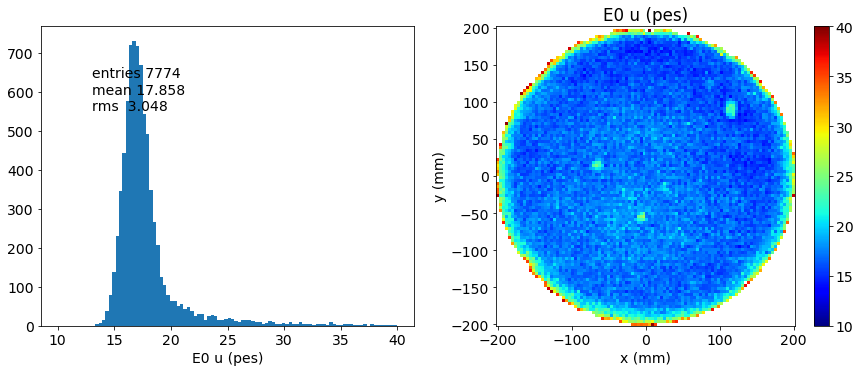

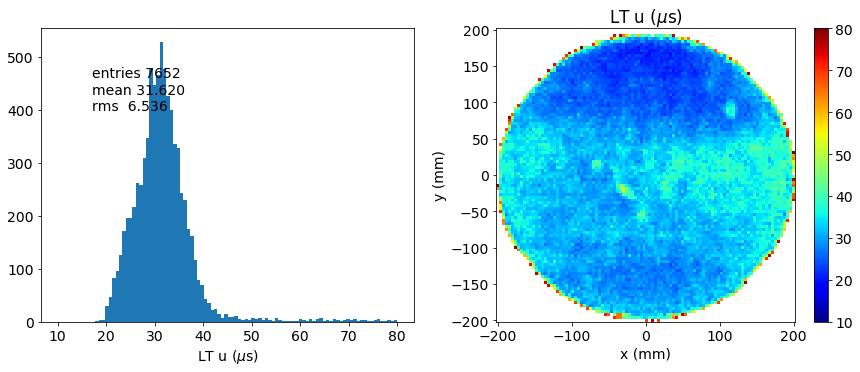

In [19]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
E0urange = (10., 40.)
LTurange = (10., 80.)
apt.plt_xymap(XYa.centers, XYa.centers, xye0.uncertainty, xyok, XYa.nbins, E0urange, 'E0 u (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xylt.uncertainty, xyok, XYa.nbins, LTurange, 'LT u ($\mu$s)');

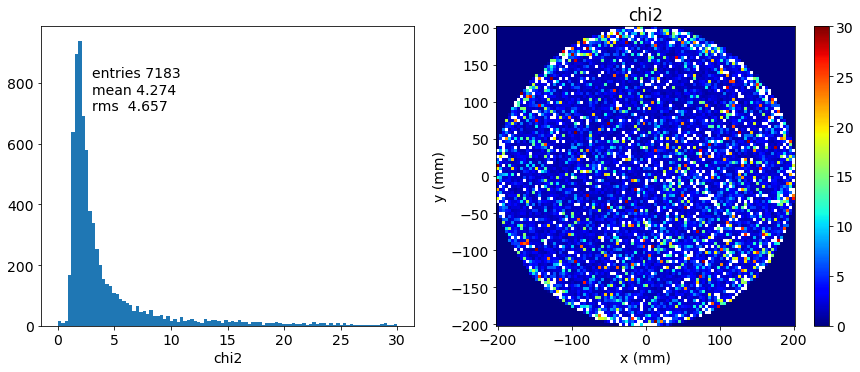

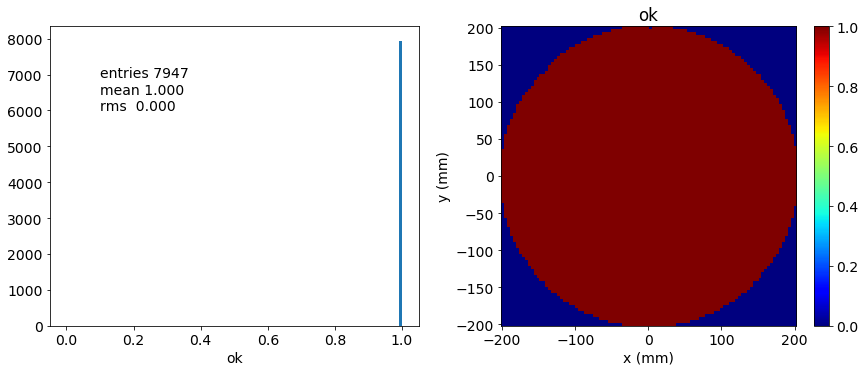

In [20]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
E0urange = (0., 100.)
LTurange = (0., 100.)
apt.plt_xymap(XYa.centers, XYa.centers, xychi2, xyok, XYa.nbins, (0., 30.), 'chi2');
apt.plt_xymap(XYa.centers, XYa.centers, xyok, xyok, XYa.nbins, (0., 1.), 'ok');

In [ ]:
xyq0, xyqlt, xyqchi2, xyqok = akr.ltmap_lsqfit(X[sel], Y[sel], Z[sel], S2q[sel], XYa.bins)

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


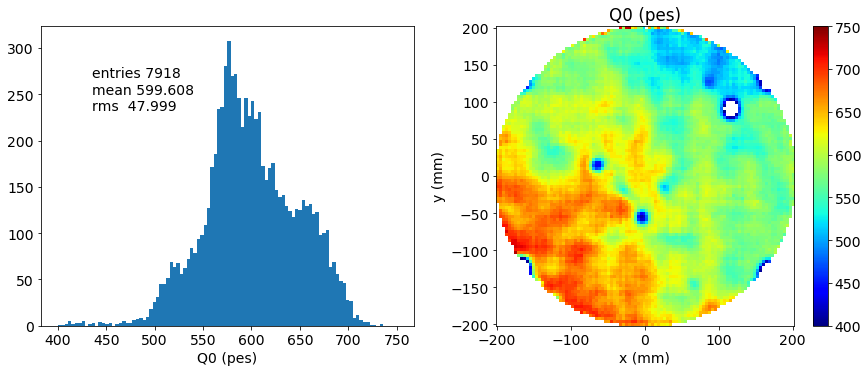

In [ ]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
QE0range = (0.4e3, 0.75e3)
QLTrange = (1.0e3, 2.5e3)
apt.plt_xymap(XYa.centers, XYa.centers, xyq0.value, xyqok, XYa.nbins, QE0range, 'Q0 (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xyqlt.value, xyqok, XYa.nbins, QLTrange, 'QLT ($\mu$s)');

In [ ]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
QE0urange = (12., 30.)
QLTurange = (20., 100.)
apt.plt_xymap(XYa.centers, XYa.centers, xye0.uncertainty , xyqok, XYa.nbins, QE0urange, 'QE0 u (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xyqlt.uncertainty, xyqok, XYa.nbins, QLTurange, 'QLT u ($\mu$s)');

In [ ]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
apt.plt_xymap(XYa.centers, XYa.centers, xyqchi2, xyqok, XYa.nbins, (0., 20.), 'chi2');
apt.plt_xymap(XYa.centers, XYa.centers, xyqok  , xyqok, XYa.nbins, (0., 1.), 'ok');

In [ ]:
Trange = (T.min(), T.max()) 
corrections.write_lifetime_correction(correction_filename, run_number, Trange, XYa.bins, 
                                      xye0, xylt, xyok, xyq0, xyqlt, xyqok, nevt)

In [ ]:
print('Done!')